In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import random
from scipy.sparse import issparse

Load Data. Our goal will be to perform an encoding and decoding of the gene expression matrix (without spatial information) and understand the steps of training a neural network via backpropagation and gradient descent.

In [2]:
adata = sc.read_h5ad('/mnt/home/cottre61/GFP-GAT/STAGATE_pyG/SpatialTranscriptomics/151673.h5ad')

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


First, as always, preprocess the data

In [3]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_name', 'layer'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

# Understanding the Structure of an Autoencoder

An **autoencoder** is a type of artificial neural network used primarily for unsupervised learning tasks, such as dimensionality reduction, denoising, and feature learning. Its goal is to learn a compressed representation (encoding) for a set of data, typically for the purpose of reconstructing the input. For our purposes in ST data analysis, we care primarily about its usefulness in dimensionality reduction (particularly as a pre-processing step to clustering / spatial domain detection) and denoising (to try and impute some of the missing gene expression measurements that occur due to dropout).

## Overview of the Autoencoder Architecture

An autoencoder typically consists of two main parts:

1. **Encoder:**  
   This part compresses the input data into a lower-dimensional representation, often referred to as the "latent space" or "bottleneck". The encoder learns a mapping from the input space $\mathbb{R}^n$ to a lower-dimensional space $\mathbb{R}^k$ (where $k < n$).

2. **Decoder:**  
   This part reconstructs the original input data from the compressed representation. It maps the latent space $\mathbb{R}^k$ back to the input space $\mathbb{R}^n$.

The overall network is trained to minimize the difference between the input and its reconstruction.

---

## 1. Encoder

- **Input Layer:**  
  The encoder starts with an input layer that accepts a data point $\mathbf{x} \in \mathbb{R}^n$.

- **Hidden Layers:**  
  One or more hidden layers transform the input into a more compact representation. In the simplest autoencoder, you might have a single hidden layer. The transformation is typically represented as:
  $$
  \mathbf{z}_1 = \mathbf{W}_1^T \mathbf{x} + \mathbf{b}_1, \quad \mathbf{h} = f(\mathbf{z}_1)
  $$
  where:
  - $\mathbf{W}_1$ is the weight matrix for the encoder.
  - $\mathbf{b}_1$ is the bias vector.
  - $f(\cdot)$ is an activation function (e.g., ReLU, sigmoid).

- **Latent Representation (Bottleneck):**  
  The output $\mathbf{h}$ of the last hidden layer is the compressed or encoded representation of the input. This is sometimes called the **bottleneck** since it forces the network to learn the most salient features of the data.

---

## 2. Decoder

- **Hidden Layers:**  
  The decoder takes the latent representation $\mathbf{h}$ and processes it through one or more hidden layers. These layers aim to "uncompress" or reconstruct the input:
  $$
  \mathbf{z}_2 = \mathbf{W}_2^T \mathbf{h} + \mathbf{b}_2, \quad \hat{\mathbf{x}} = g(\mathbf{z}_2)
  $$
  where:
  - $\mathbf{W}_2$ and $\mathbf{b}_2$ are the weights and biases of the decoder.
  - $g(\cdot)$ is an activation function (which can be the same as or different from $f$).  
    In our example, we will utilize the popular ReLU activation function for both layers.

- **Output Layer:**  
  The final layer of the decoder produces the reconstructed output $\hat{\mathbf{x}} \in \mathbb{R}^n$. Often, the same activation function is used as in the encoder or a linear activation might be chosen for regression tasks.

---

## Loss Function

The autoencoder is trained by minimizing a loss function that measures the difference between the original input $\mathbf{x}$ and its reconstruction $\hat{\mathbf{x}}$. A common choice is the **Mean Squared Error (MSE)**:
$$
\mathcal{L} = \frac{1}{n}\|\mathbf{x} - \hat{\mathbf{x}}\|^2
$$
Other loss functions (e.g., cross-entropy) might be used depending on the nature of the data and the application (for example, if the data is binary). However, most deep learning models for ST data analysis use some variant of MSE loss.

---

## Backpropagation and Gradient Descent in the Autoencoder

After obtaining the reconstruction $\hat{\mathbf{x}}$ via the forward pass, the autoencoder must adjust its parameters (weights and biases) so that $\hat{\mathbf{x}}$ more closely resembles the original input $\mathbf{x}$. This adjustment is made by computing gradients via **backpropagation** and updating parameters with **gradient descent**.

### 1. The Forward Pass (Recap)

- **Encoder:**  
  The input $\mathbf{x}$ is transformed to a hidden representation:
  $$
  \mathbf{z}_1 = \mathbf{W}_1^T \mathbf{x} + \mathbf{b}_1, \quad \mathbf{h} = f(\mathbf{z}_1)
  $$
  Here, $f$ is typically a non-linear activation such as ReLU.

- **Decoder:**  
  The hidden representation is transformed back to a reconstruction:
  $$
  \mathbf{z}_2 = \mathbf{W}_2^T \mathbf{h} + \mathbf{b}_2, \quad \hat{\mathbf{x}} = g(\mathbf{z}_2)
  $$
  Again, $g$ might be ReLU or another activation function.

- **Loss Calculation:**  
  The error (loss) between the input and the reconstruction is measured, commonly using the Mean Squared Error:
  $$
  \mathcal{L} = \|\mathbf{x} - \hat{\mathbf{x}}\|^2
  $$

### 2. The Backward Pass (Backpropagation)

Backpropagation applies the chain rule to determine how changes in each parameter affect the loss. The process proceeds in the following steps:

#### a. Error at the Output Layer

- **Compute the Error:**  
  The difference between the reconstruction and the input is:
  $$
  \text{error} = \hat{\mathbf{x}} - \mathbf{x}
  $$
- **Derivative of the Loss:**  
  For the squared error loss, the derivative with respect to $\hat{\mathbf{x}}$ is:
  $$
  \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{x}}} = 2 (\hat{\mathbf{x}} - \mathbf{x})
  $$

#### b. Gradients through the Decoder

- **Activation Derivative:**  
  Since $\hat{\mathbf{x}} = g(\mathbf{z}_2)$ (with $g$ being ReLU in our example), compute:
  $$
  g'(z_2) = \begin{cases} 1, & z_2 > 0 \\ 0, & z_2 \leq 0 \end{cases}
  $$
- **Gradient with Respect to $\mathbf{z}_2$:**  
  Combine the loss derivative and the activation derivative:
  $$
  \frac{\partial \mathcal{L}}{\partial \mathbf{z}_2} = \frac{\partial \mathcal{L}}{\partial \hat{\mathbf{x}}} \odot g'(\mathbf{z}_2)
  $$
  where $\odot$ denotes element-wise multiplication.

- **Gradients for Decoder Parameters:**
  - **Weights $\mathbf{W}_2$:**  
    The gradient is the outer product of the hidden layer activations $\mathbf{h}$ and the computed gradient:
    $$
    \frac{\partial \mathcal{L}}{\partial \mathbf{W}_2} = \mathbf{h} \cdot \left(\frac{\partial \mathcal{L}}{\partial \mathbf{z}_2}\right)^T
    $$
  - **Biases $\mathbf{b}_2$:**  
    The gradient is simply:
    $$
    \frac{\partial \mathcal{L}}{\partial \mathbf{b}_2} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_2}
    $$

#### c. Gradients through the Encoder

- **Propagating Error to the Hidden Layer:**  
  The error signal at the hidden layer is influenced by the decoder’s weights:
  $$
  \frac{\partial \mathcal{L}}{\partial \mathbf{h}} = \mathbf{W}_2 \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{z}_2}
  $$
- **Activation Derivative for the Encoder:**  
  Given $\mathbf{h} = f(\mathbf{z}_1)$ with $f$ being ReLU:
  $$
  f'(z_1) = \begin{cases} 1, & z_1 > 0 \\ 0, & z_1 \leq 0 \end{cases}
  $$
- **Gradient with Respect to $\mathbf{z}_1$:**  
  Combine the hidden error and the derivative of the activation:
  $$
  \frac{\partial \mathcal{L}}{\partial \mathbf{z}_1} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}} \odot f'(z_1)
  $$

- **Gradients for Encoder Parameters:**
  - **Weights $\mathbf{W}_1$:**  
    The gradient is:
    $$
    \frac{\partial \mathcal{L}}{\partial \mathbf{W}_1} = \mathbf{x} \cdot \left(\frac{\partial \mathcal{L}}{\partial \mathbf{z}_1}\right)^T
    $$
  - **Biases $\mathbf{b}_1$:**  
    The gradient is:
    $$
    \frac{\partial \mathcal{L}}{\partial \mathbf{b}_1} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_1}
    $$

### 3. Updating Parameters with Gradient Descent

Once the gradients are computed for all parameters, gradient descent is used to update them. For a parameter $\theta$ (which could be any weight or bias), the update rule is:
$$
\theta \leftarrow \theta - \eta \frac{\partial \mathcal{L}}{\partial \theta}
$$
where:
- $\eta$ is the learning rate, which controls the size of the update step.

This update is applied to each parameter, gradually reducing the loss and improving the network's ability to reconstruct the input.

---

## Why Use Autoencoders (Particularly for scRNAseq or ST)?

- **Dimensionality Reduction:**  
  Autoencoders can learn a compact representation of high-dimensional data, which can be useful for visualization or as input to other machine learning models.

- **Denoising:**  
  They can be trained to remove noise from data by learning a representation that captures the underlying structure rather than the noise.

---

## Summary

An autoencoder is a powerful tool for unsupervised learning that consists of an encoder for dimensionality reduction and a decoder for reconstruction. By forcing the network to compress data into a lower-dimensional representation and then reconstruct it, the autoencoder learns to capture the most important features of the data.

**Backpropagation** and **gradient descent** are at the core of training the autoencoder:
- **Backpropagation** uses the chain rule to compute gradients of the loss with respect to each parameter.
- **Gradient Descent** then updates the parameters in the opposite direction of the gradient, minimizing the loss over successive iterations.

Through these steps, the network iteratively improves its reconstruction of the input data, enabling applications such as effective denoising and dimensionality reduction in the context of ST data analysis.


Given our autoencoder, we can train it on our gene expression data and evaluate its performance on two tasks. First, we can use the embedded representation of our expression profiles as the input to a clustering algorithm. Next, we can consider the decoder output as a 'denoised' or 'imputed' expression matrix where, hopefully, the model has learned an even more informative representation of the genes' expression acros the tissue (recall that the original data was noisy due to potential dropout events). 

In [4]:
class Autoencoder:
    def __init__(self, input_dim, lr=0.01):
        """
        Initialize the four-layer autoencoder with sigmoid activations.

        Architecture:
            Input (input_dim) -> Layer1 (128) -> Layer2 (32) -> Layer3 (128) -> Output (input_dim)
        
        Parameters:
            input_dim (int): Dimensionality of the input data.
            lr (float): Learning rate for gradient descent.
        """
        self.input_dim = input_dim
        self.lr = lr
        
        # Define the dimensions of each layer.
        self.layer1_dim = 128
        self.layer2_dim = 32  # (embedding)
        self.layer3_dim = 128
        self.layer4_dim = input_dim  # Output same as input
        
        # initialization
        self.W1 = np.random.randn(input_dim, self.layer1_dim) * np.sqrt(1.0 / input_dim)
        self.b1 = np.zeros((1, self.layer1_dim))
        
        self.W2 = np.random.randn(self.layer1_dim, self.layer2_dim) * np.sqrt(1.0 / self.layer1_dim)
        self.b2 = np.zeros((1, self.layer2_dim))
        
        self.W3 = np.random.randn(self.layer2_dim, self.layer3_dim) * np.sqrt(1.0 / self.layer2_dim)
        self.b3 = np.zeros((1, self.layer3_dim))
        
        self.W4 = np.random.randn(self.layer3_dim, self.layer4_dim) * np.sqrt(1.0 / self.layer3_dim)
        self.b4 = np.zeros((1, self.layer4_dim))
    
    def sigmoid(self, x):
        """Sigmoid activation function."""
        return 1.0 / (1.0 + np.exp(-x))
    
    def d_sigmoid(self, x):
        """
        Derivative of the sigmoid function.
        
        Given an input x, where sigmoid(x)=s, the derivative is s*(1-s).
        It is common (and numerically more stable) to compute the derivative using the activated output.
        """
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, X):
        """
        Perform a forward pass through the network.
        
        Parameters:
            X (numpy array): Input data of shape (m, input_dim), where m is the number of samples.
        
        Returns:
            embedding (numpy array): The 50-dimensional hidden representation (m, 50).
            reconstruction (numpy array): The reconstructed output (m, input_dim).
        """
        self.X = X  # Store input for backpropagation
        # Encoder
        self.Z1 = np.dot(X, self.W1) + self.b1    
        self.A1 = self.sigmoid(self.Z1)          
        
        self.Z2 = np.dot(self.A1, self.W2) + self.b2 
        self.A2 = self.sigmoid(self.Z2)              # embedding
        
        # Decoder
        self.Z3 = np.dot(self.A2, self.W3) + self.b3  
        self.A3 = self.sigmoid(self.Z3)               
        
        self.Z4 = np.dot(self.A3, self.W4) + self.b4  
        self.A4 = self.sigmoid(self.Z4)               # reconstruction
        
        return self.A2, self.A4
    
    def compute_loss(self, X):
        """
        Compute the mean squared error (MSE) loss between the input and the reconstruction.
        
        Parameters:
            X (numpy array): Original input data of shape (m, input_dim).
        
        Returns:
            loss (float): Mean squared error.
        """
        m = X.shape[0]
        loss = np.sum((X - self.A4) ** 2) / m
        return loss
    
    def backward(self, X):
        """
        Perform the backward pass (backpropagation) and update the network's parameters.
        
        Parameters:
            X (numpy array): Input data of shape (m, input_dim).
        """
        m = X.shape[0]
        # Compute gradient of loss wrt. output activation A4.
        # For MSE loss, dLoss/dA4 = (2/m)*(A4 - X)
        dA4 = (2.0 / m) * (self.A4 - X)  # (m, input_dim)
        
        # Backprop through the output sigmoid.
        # dA4/dZ4 = sigmoid(Z4)*(1-sigmoid(Z4)) = A4*(1-A4)
        dZ4 = dA4 * (self.A4 * (1 - self.A4))  
        dW4 = np.dot(self.A3.T, dZ4)           
        db4 = np.sum(dZ4, axis=0, keepdims=True)  
        
        # Backpropagate to third layer
        dA3 = np.dot(dZ4, self.W4.T)            
        dZ3 = dA3 * (self.A3 * (1 - self.A3))     
        dW3 = np.dot(self.A2.T, dZ3)            
        db3 = np.sum(dZ3, axis=0, keepdims=True)  
        
        # Backpropagate to second layer (embedding)
        dA2 = np.dot(dZ3, self.W3.T)            
        dZ2 = dA2 * (self.A2 * (1 - self.A2))     
        dW2 = np.dot(self.A1.T, dZ2)            
        db2 = np.sum(dZ2, axis=0, keepdims=True) 
        
        # Backpropagate to first layer
        dA1 = np.dot(dZ2, self.W2.T)            
        dZ1 = dA1 * (self.A1 * (1 - self.A1))    
        dW1 = np.dot(X.T, dZ1)                 
        db1 = np.sum(dZ1, axis=0, keepdims=True)  
        
        # Update parameters via gradient descent.
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, epochs=200):
        """
        Train the autoencoder on the full dataset.
        
        Parameters:
            X (numpy array): Input data of shape (m, input_dim).
            epochs (int): Number of training epochs.
        
        Returns:
            loss_history (list): List of loss values per epoch.
        """
        loss_history = []
        for epoch in range(epochs):
            self.forward(X)
            loss = self.compute_loss(X)
            loss_history.append(loss)
            self.backward(X)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.6f}")
            if epoch > 100 and (np.abs(loss_history[epoch] - loss_history[epoch-1]) / loss_history[epoch]) < 1e-3:
                print('Converged')
                break
        return loss_history

    def embed_and_reconstruct(self, X):
        """
        Compute the embedding and reconstruction for the input data.
        
        Parameters:
            X (numpy array): Input data of shape (m, input_dim).
        
        Returns:
            embedding (numpy array): The 50-dimensional representation (m, 50).
            reconstruction (numpy array): The reconstructed output (m, input_dim).
        """
        embedding, reconstruction = self.forward(X)
        return embedding, reconstruction


In [5]:
X = adata.X
if issparse(X):  
    X = X.toarray()
# recall we need the data to have shape (cells by genes) to run the autoencoder 
print('Data Shape', X.shape)
num_genes = X.shape[1]
num_cells = X.shape[0]
# train autoencoder
ae = Autoencoder(num_genes)
loss = ae.train(X)
embeddings, reconstructions = ae.embed_and_reconstruct(X)
print("Embedding shape:", embeddings.shape)       
print("Reconstruction shape:", reconstructions.shape)

Data Shape (3639, 3000)
Epoch 0: Loss = 1344.863962
Epoch 10: Loss = 894.172178
Epoch 20: Loss = 721.064496
Epoch 30: Loss = 685.254348
Epoch 40: Loss = 674.349100
Epoch 50: Loss = 669.509429
Epoch 60: Loss = 666.848497
Epoch 70: Loss = 665.184757
Epoch 80: Loss = 664.054111
Epoch 90: Loss = 663.239752
Epoch 100: Loss = 662.627500
Converged
Embedding shape: (3639, 32)
Reconstruction shape: (3639, 3000)


We can plot the loss over time to observe how the model converges to its learned representation of the data

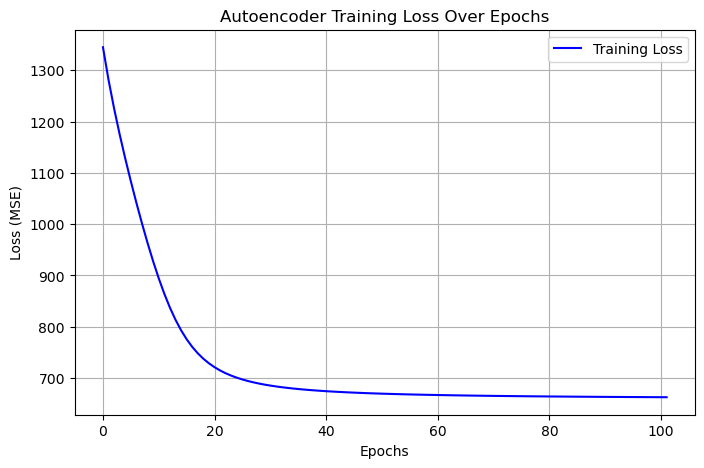

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(loss)), loss, label="Training Loss", color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Autoencoder Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

Now we can actually utilize the autoencoder features for one of the tasks in ST / scRNAseq data analysis: Clustering (Spatial Domain Detection) on the embedding (output of encoder) 

In [7]:
adata.obsm['encoder_embedding'] = embeddings
adata.obsm['decoder_reconstruction'] = reconstructions

/tmp/ipykernel_57154/1544958867.py:1: ImplicitModificationWarning: Setting element `.obsm['encoder_embedding']` of view, initializing view as actual.
  adata.obsm['encoder_embedding'] = embeddings


In [8]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='encoder_embedding')

2025-02-13 18:25:32.683800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 18:25:35.156724: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-13 18:25:35.156896: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-13 18:25:49.499951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-

In [9]:
sc.tl.louvain(adata, resolution=0.7)
sc.tl.umap(adata)

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


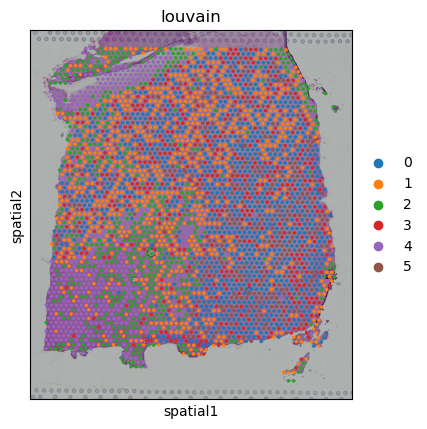

In [10]:
sc.pl.spatial(adata,color='louvain')

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


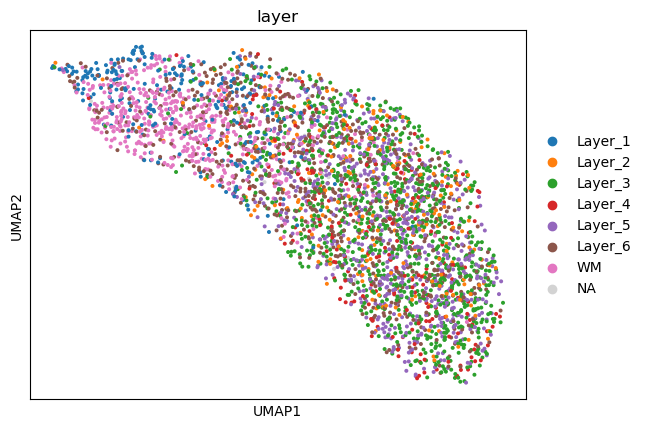

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


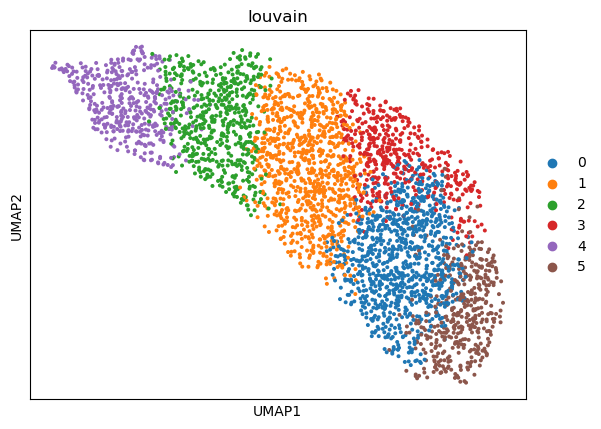

In [11]:
sc.pl.umap(adata, color='layer',cmap='tab10')
sc.pl.umap(adata, color='louvain',cmap='tab10')

And gene imputation

[<Axes: title={'center': 'Denoised_TFF1'}, xlabel='spatial1', ylabel='spatial2'>]

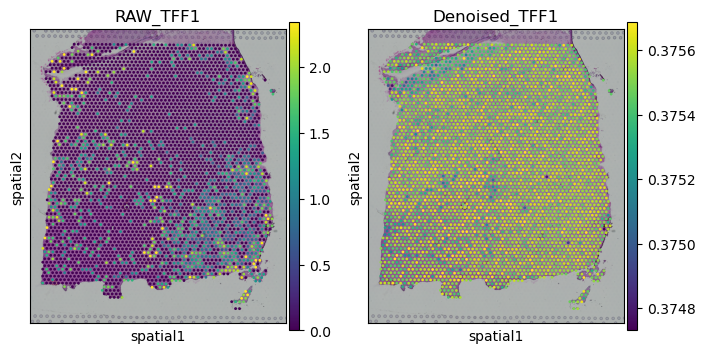

In [12]:
adata.layers["ReX"] = adata.obsm["decoder_reconstruction"]
gene = 'TFF1'
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, img_key="hires", color=gene, show=False, ax=axs[0], title='RAW_'+gene, vmax='p99')
sc.pl.spatial(adata, img_key="hires", color=gene, show=False, ax=axs[1], title='Denoised_'+gene, layer='ReX', vmax='p99')

Again, we see that the lack of spatial information leads to poor performance in the model. This motivates the introduction of graph based methods to model the spatial dependencies which we will discuss next week. Specifically, how can we allow the embedded representation of each cell's expression profile to be influenced by its spatial neighbors? This is achieved through a technique called Graph Message Passing. 

I will say, I am actually somewhat shocked how poorly the model did. I think another reason for this is the inherent noisiness of ST data due to dropouts. The way researchers usually deal with this is by masking some of the non-zero entries in the matrix, which forces the model to learn that structure more effectively. This is commonly referred to as a denoising autoencoder. I think perhaps the combination of not including spatial information along with not providing an effective framework to distinguish noise from signal in the data is what led to such awful performance. These are issues we will address as the semester goes on. 

Furthermore, the code runs extremely slowly. We can use libraries such as tensorflow or pytorch to speed up the implementation in practice, rather than coding it from scratch. 